# Loco Mosquito

The program that imports the IR spectra of the mosquitoes, cleans them, screens them eliminating the badly measured ones and extracts the most interesting data from them!

Written by Mario González Jiménez  
School of Chemistry, University of Glasgow  
Glasgow G12 8QQ, UK.



### Changelog

- Version 1.0.
    - Original Program
- Version 1.1
    - Adapted for new file names with country code.
    - Added code to avoid processing files with wrong names.
    - Solved bug in the code that plots a spectrum and the selected wavenumbers.
- Version 2.0
    - Added an algorithm for being able to read files with names without a country code.
    - It plots a bar and whiskers graph with the results of the mosquitoes.
    - Added an algorithm to detect when the selected wavenumbers are out of the measured ranges.
- Version 3.0
    - Supports ``.mzz`` files.
- Version 3.1
    - Supports the new (after Ifakara meeting) and the old naming systems.
    - New wrong-mosquito-stubborn-namer-proof system.
    - Included all the modifications from Loco Mosquito "Mwanga edition", including the possibility of using two wavenumbers to select ranges instead of individual peaks.
    - Corrects the selection of peaks in case they have wavenumbers that are not in the spectral range.
- Version 3.2
    - Ready for the analysis of a large number of files in different folders.
    - Makes a list with the files with wrong names.
- Version 3.3
    - Deals with errors in the dates of the mosquitoes.
- Version 4.0
    - Ignores the name of the ``*.tmp`` file inside the ``*.mzz`` file.
    - Discriminates between the rearing conditions of the mosquitoes.
    - Includes an algorithm to select what mosquitoes you want to use in the final matrix.
- Version 4.1
    - Added in tqdm to make use of a progress bar during the long phase of loading in spectra.
    - Modified reading the spectra to include the country. Further changes throughout shift the spectral position in the matrices to acommodate the country matrix location.
    - Added in a subtotal in the tables with the number of mosquitoes.
    - **Version made in collaboration with Joshua Mitton, University of Glasgow**
- Version 4.2
    - Solved some bugs that affected the code (only in Ifakara).
- Version 5.0
    - Revised comments to facilitate use of the program (and the acceptance of paper by the editors).
    - It is not longer necessary to be careful with the way you introduce the path name. Now it deals with different OS.
    - Includes ``Candy 0.0``: the algorithm that compensates the atmosferic intrusion in the spectra that weren't well measured
    - Minor changes to the tables with the number of mosquitoes.




### Useful modules

This are the modules that will be used by Loco mosquito

In [33]:
#we will use numpy to process the data
import numpy as np 
# to remove the water and carbon dioxide spectra from our data
from scipy import optimize

# to make the figures
import matplotlib.pyplot as plt 

# to manage the files 
import os
# to deal with file paths on Windows, Mac and Linux
from pathlib import Path 
# to manage the data textfiles
import csv 
# to decompress the mzz files
import zipfile 
import zlib

# to control the program execution
import time 
# to know the progress in the slow parts
from tqdm import tqdm 

### Loading the spectra

All spectra must be in the ``*.dpt`` format, which is the format Bruker's OPUS program uses to save the data as a text file. Spectra can also be saved as ``*.mzz`` files which is the format we have designed to save spectra as small as possible. The spectra must be sharing a common folder (it doesn't matter if they are organised in subfolders) and with a descriptive name of their status, which must follow the following agreed format:

```
kk-C-xxD-yy-zz-mm-888888-555555-33.dpt (or *.mzz)
```

where:

* **kk**: Species code
    * **AA**: _Anopheles arabiensis_
    * **AG**: _Anopheles gambiae_
    * **AC**: _Anopheles coluzzi_
* **C**: Country code
    * **B**: Burkina Faso
    * **T**: Tanzania
    * **S**: Scotland
* **xx**: Age of the mosquito in days
* **yy**: Status of the mosquito
    * **BF**: Blood fed
    * **SF**: Sugar fed
    * **UF**: Unfed
    * **GR**: Gravid
* **zz**: Insecticide resistance
    * **RE**: Resistant
    * **SU**: Susceptible
    * **UN**: Unknown
* **mm**: Rear conditions
    * **TL**: Time course lab
    * **TF**: Time course field
    * **VF**: Validation Field
    * **RU**: Rear unknown
* **888888**: Date the mosquito was measured
* **555555**: Date the mosquito was collected
* **33**: Mosquito number identifier (ignored during the processing)

Although it is also possible to read files with the old naming systems without country code, insecticide resistance, or rear conditions:

```
kk-xxD-yy-888888-555555-zz.dpt (or *.mzz)
```

```
kk-C-xxD-yy-888888-555555-zz.dpt (or *.mzz)
```

```
kk-C-xxD-yy-zz-888888-555555-zz.dpt (or *.mzz)
```

Here is the algorithm to load the spectra, but first you must indicate the folder location. To do this, the easiest way to proceed is just going to a file in the folder where the spectra are, right-click on it, select properties, and, then, copy the text at the right of "Location:". **It is not longer necessary** to add `\` or `/` at the end of the path.

In [35]:
spectra_path = input("Please, indicate the folder location: ")

Please, indicate the folder location: /home/josh/Documents/Mosquito_Project/New_Data/Data/MIMIdata_update_19_02/


In [36]:
a = time.time()
# we include the path module that helps a lot with the / or \ problem
spectra_path = Path(spectra_path)
# find all the .mzz and .dpt files in the folder (and its subfolders)
dptfiles = []
mzzfiles = []
for root, dirs, files in os.walk(spectra_path):
    for file in files:
        if file.endswith(".dpt"):
             dptfiles.append(Path(root) / Path(file))
        elif file.endswith(".mzz"):
             mzzfiles.append(Path(root) / Path(file))
#If there are *.mzz files, we will not consider the *.dpt files
if len(mzzfiles) > 0:
    spectra_names = mzzfiles
    mzzq = True
else:
    spectra_names = dptfiles
    mzzq = False
# we prepare the lists that are going to contain all the info collected
matrix = []
list_ages = []
list_status = []
list_species = []
list_rear = []
list_country = []
wrong_named = []
# Now we load the spectra in a matrix
for i in tqdm(spectra_names):
    # To obtain the info from the name of the file, first we split the name in the different sections:
    tmp = os.path.basename(i).split(".")[0].split(" ")[0].split("-")
    # The first part in all the naming systems is always the species
    j = 0
    species = tmp[j]
    # Species have to be named with two letters. If not we will not consider them:
    if len(species) != 2:
        wrong_named.append(i)
        continue # we don't add this spectrum to the matrix
    # if we have passed this test, we check if the specie is already seen
    if species in list_species:
        pass
    else:
        list_species.append(species)
    # And then we move to the country, then age
    j += 1
    # If there is the country code, add it
    if len(tmp[j]) <= 2:
        country = tmp[j]
        if country in list_country:
            pass
        else:
            list_country.append(country)
        j += 1
    # And because there is always somebody that forgets to add the 0 in the ages smaller than 10 days...
    if len(tmp[j]) == 2:
        age = '0' + tmp[j]
    else:
        age = tmp[j]
    age = age[:2]
    # Ages have to be named with three characteres. If not we will not consider them:
    if len(age) != 2:
        wrong_named.append(i)
        continue # we don't add this spectrum to the matrix
    if age in list_ages:
        pass
    else:
        list_ages.append(age)
    # The next part is the status of the mosquito
    j += 1
    status = tmp[j]
    # To indicate the status, the spectra have to use two letters. If not, we will not consider them:
    if len(status) != 2:
        wrong_named.append(i)
        continue # we don't add this spectrum to the matrix
    if status in list_status:
        pass
    else:
        list_status.append(status)
    # And the only info left is the collection and measurement dates
    j += 1
    # Some files include info about insecticide resistance and rear condition. We check if they are stated
    if len(tmp[j]) == 2:
        # it must start with R or S or U to be be the insecticide resistance (at this moment we dont care about this aspect)
        if tmp[j][0] == "R" or tmp[j][0] == "S" or tmp[j][0] == "U":
            j += 1
            
    # Now we check the rearing condition:
    if len(tmp[j]) == 2:
        rear = tmp[j]
        # And then we move to the dates
        j += 1
    else:
        rear = 'RU'
        wrong_named.append(i)
    # if we have passed this test, we check if the specie is already seen
    if rear in list_rear:
        pass
    else:
        list_rear.append(rear)
    # Now we check that the dates are well written and if not we discard the file
    if len(tmp[j]) != 6:
        wrong_named.append(i)
        continue
    try:
        colday = time.mktime(time.strptime(tmp[j],"%y%m%d"))
    except:
        wrong_named.append(i)
        continue
    j += 1
    if len(tmp[j]) != 6:
        wrong_named.append(i)
        continue
    try:
        mesday = time.mktime(time.strptime(tmp[j],"%y%m%d"))
    except:
        wrong_named.append(i)
        continue
    stime = abs((mesday - colday) / (3600 * 24))
    # And finally the spectrum and its characteristics
    if mzzq == False:
        with open(i, 'rb') as tmp:
            avmi = (line.replace(b'\t',b',') for line in tmp)
            spectrum = np.genfromtxt(avmi, delimiter=',')
        start = spectrum[0,0]
        end = spectrum[-1,0]
        ls = len(spectrum)
        spectrum = np.transpose(spectrum)[1]    
    else:
        with zipfile.ZipFile(i) as myzip:
            tmpname = myzip.namelist()[0]
            with myzip.open(tmpname) as myfile:
                spectrum = np.genfromtxt(myfile, delimiter=',')
        start = spectrum[0]
        end = spectrum[1]
        ls = int(spectrum[2])
        spectrum = spectrum[3:]
    matrix.append([species,age,status,country,colday,mesday,rear,stime,[start,end,ls],spectrum])
list_species = sorted(list_species)
list_ages = sorted(list_ages)
list_status = sorted(list_status)
list_country = sorted(list_country)
list_rear = sorted(list_rear)
b = time.time()
print("This last process has lasted " + str(round(b-a,3)) + " s. " + str(len(wrong_named)) + " files were not read because their name")

100%|██████████| 43041/43041 [02:59<00:00, 240.41it/s]

This last process has lasted 179.552 s. 0 files were not read because their name


In [37]:
wrong_named

[]

In [41]:
print(len(matrix))

43041


The following code allows us to count the number of mosquitoes for each specie, age, and status. 

In [42]:
mos_acc = []
for j in range(len(list_rear)):
    mos_acc.append(np.zeros((len(list_species),len(list_status),len(list_ages)),dtype=int)) # We create an empty table for the 
    for i in range(len(matrix)):
        if matrix[i][6] == list_rear[j]:
            x = list_species.index(matrix[i][0])
            y = list_status.index(matrix[i][2])
            z = list_ages.index(matrix[i][1])
            mos_acc[j][x][y][z] += 1
            
mos_acc_2 = [np.zeros((len(list_species),len(list_status))) for i in range(3)]
for i in range(len(mos_acc)):
    for j in range(mos_acc[0].shape[0]):
        for k in range(mos_acc[0].shape[1]):
            mos_acc_2[i][j][k] = np.sum(mos_acc[i][j][k])

# We show it in a beautiful way
width = ((len(list_ages) + 2) * 5) - 2
print()
for j in range(len(list_rear)):
    if list_rear[j] == "TF":
        nare = "Time course Field:"
    elif list_rear[j] == "TL":
        nare = "Time course Lab:"
    elif list_rear[j] == "VF":
        nare = "Validation Field:"
    else:
        nare = "Rear Unknown"
    print(nare)
    for i in range(mos_acc[j].shape[0]):
        print(" " * (round(width/2) -2) + list_species[i])
        print("=" * width)
        print("    "+'   '.join(map(str, list_ages))+"  "+'Total') 
        print("-" * width)
        for k in range(mos_acc[j].shape[1]):
            print(list_status[k] + " " + "  ".join(["%3.0f" % dx for dx in mos_acc[j][i][k]]) + "   " + "".join("%3.0f" % mos_acc_2[j][i][k]))
        print()
        print(('Total '+list_species[i]+' : '+str("%3.0f" % np.sum(mos_acc_2[j][i]))))
    print(" " * width + "Total: " + str(np.sum(mos_acc[j])))
    print()
print()
print("=" * width)
print("|" + " " * (round(width/3)) +   "Total mosquitoes: " + str(np.sum(mos_acc)) + " " * (round(width/3)+5) + "|")
print("=" * width)


Time course Field:
                                            AA
    01   02   03   04   05   06   07   08   09   10   11   12   13   14   15   16   17  Total
---------------------------------------------------------------------------------------------
BF   0    0   96  157  101    0    0    0   71   78   71    0    0    0  102  101  101   878
GR   0    0    0    0  102  102  101    0    0    0   98  101   91    0    0    0   82   677
SF  71   81   95  198  206  259  325  406  303  364  195  286  331  430  312  308  213   4383
UN   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0     0

Total AA : 5938
                                            AC
    01   02   03   04   05   06   07   08   09   10   11   12   13   14   15   16   17  Total
---------------------------------------------------------------------------------------------
BF   0    0   51   41    0    0    0    0    0    0   60   45   32   28   39   36   31   363
GR   0    0    0    0    0 



## Detection of spectra with low quality

### Spectra with low intensity

If the mosquito was not well placed at the ATR's crystal, the intensity of the whole spectrum is small. Our experience says that we can use as reference the small plateau between 400 and 500 wavenumbers that the mosquito spectra usually have. Since the spectrometer with ZnSe optics only can reach to 500 wavenumbers, it doesn't matter if we extend this range to 600 cm<sup>-1</sup>. Then if the average of this reference is smaller than 0.11, the spectrum doesn't have enough quality to be scaled and, then, of course, employed.

In [43]:
# A list of the discarted spectra will be collected:
bad_spectra = []
for i in range(len(matrix)):
    # first we calculate the position of the points that comprise that section of the spectrum
    if matrix[i][8][1] < 600 and matrix[i][8][1] > 400:
        sta = int(round((((matrix[i][8][2] - 1) / (matrix[i][8][1] - matrix[i][8][0])) * (600 - matrix[i][8][0])) + 1)) - 1
        end = matrix[i][8][2]
    elif matrix[i][8][1] <= 400:
        sta = int(round((((matrix[i][8][2] - 1) / (matrix[i][8][1] - matrix[i][8][0])) * (600 - matrix[i][8][0])) + 1)) - 1
        end = int(round((((matrix[i][8][2] - 1) / (matrix[i][8][1] - matrix[i][8][0])) * (400 - matrix[i][8][0])) + 1)) - 1
    else:
        sta = 0 # if the spectrum doesn't reach 600 cm-1 we cannot prove if the spectrum has enough intensity
        raise Exception("The spectrum {} doesn't reach 600 cm-1".format(spectra_names[1]))
    # Now we check the intensity of the spectra in that region. If is not over 0.1 we discard the spectrum
    if np.average(matrix[i][9][sta:end]) < 0.11:
        bad_spectra.append("LI: " + str(spectra_names[i]))
        matrix[i] = None
if (bad_spectra) == 1:
    print("1 spectrum has been discarded because its low intensity")
else:
    print(str(len(bad_spectra)) + " spectra have been discarded because their low intensity")

993 spectra have been discarded because their low intensity


In [44]:
print(len(matrix))

43041


### Spectra with abnormal background

Bruker spectrometers sometimes measure spectra whose characteristics have been masked by a high-absorbance band covering the entire mid-infrared region. I do not know the origin of this band. I used to think it was due to the interaction of the ATR crystal with the metallic anvil, but now I'm inclined to think it's due to some vibration or shock during measurement. Sometimes these spectra pass the previous filters and it is necessary to remove them. To do it that we are going to do is to select the wavenumber with less signal from the mosquito (this wavenumber is usually 1900 cm<sup>-1</sup>) and look for outliers at that frequency.

In [45]:
bs = 0 # counter for the number of spectra discarderd 
# we calculate the fences of the data set based in a value we can choose (in statistics 1.5 times
# the interquartile range is the inner fence and 3 times is the outer fence)
l = 2.5
# We look for the point at 1900 cm-1 and add it to the list of intensities
li = []
for i in range(len(matrix)):
    if matrix[i]: #to check if we have spectra
        # Now one would spect that the spectrum will reach 3900 so the program will not check it out.
        sta = int(round((((matrix[i][8][2] - 1) / (matrix[i][8][1] - matrix[i][8][0])) * (1900 - matrix[i][8][0])) + 1)) - 1
        li.append(matrix[i][9][sta])
q3, q1 = np.percentile(li, [75 ,25])
ir = q3 - q1
for i in range(len(matrix)):
    if matrix[i]: #to check if we have spectra
        sta = int(round((((matrix[i][8][2] - 1) / (matrix[i][8][1] - matrix[i][8][0])) * (1900 - matrix[i][8][0])) + 1)) - 1
        if matrix[i][9][sta] > (l * ir + q3) or matrix[i][9][sta] < (q1 - l * ir):
            bs +=1
            bad_spectra.append("SA: " + str(spectra_names[i]))
            matrix[i] = None 
if (bs) == 1:
    print("1 spectrum has been discarded because it was distorted by the anvil")
else:
    print(str(bs) + " spectra have been discarded because they were distorted by the anvil")

441 spectra have been discarded because they were distorted by the anvil


In [46]:
print(len(matrix))

43041


### Spectra with atmospheric interferences

If the spectra were measured after the change of the beamsplitter or after installing the ATR and the background was not correctly measured, the spectra will be with the interference of the water and CO<sub>2</sub> spectra. In the case of water vapour, its IR spectrum has three bands with many narrow peaks that can appear as noise: one between 4000 and 3400 cm<sup>-1</sup>, other between 2200 and 1300 cm<sup>-1</sup> and the last one starts to appear below 800 cm<sup>-1</sup>. CO<sub>2</sub> has one strong band at 2345 cm<sup>-1</sup> and two smaller bands (unless you use a very fine resolution, you will not see its narrow peaks) at 3650 and 750 cm<sup>-1</sup>. Since some of this features appear in the same regions than the most interesting peaks from mosquitos, it is necessary to get rid of them. The following algorithms (originally part of a program named with another Iggy Pop song: ``Candy 0.0``) check the presence of these of these bands:

In [47]:
bs = 0 # counter for the number of spectra discarderd
mycollection = []
# Now we define a function to calculate the R-squared coefficient of the fitting of our data to a polynomial
def rs_pf(x, y, degree):
    coeffs = np.polyfit(x, y, degree)
    # r-squared
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results = ssreg / sstot

    return results

# Here take that the section of the data between 3900 and 3500 cm-1 and check if it fits well to a 5th degree polinomial
for i in range(len(matrix)):
    if matrix[i]: #to check if we have spectra
        # Now one would spect that the spectrum will reach 3900 so the program will not check it out.
        sta = int(round((((matrix[i][8][2] - 1) / (matrix[i][8][1] - matrix[i][8][0])) * (3900 - matrix[i][8][0])) + 1)) - 1
        end = int(round((((matrix[i][8][2] - 1) / (matrix[i][8][1] - matrix[i][8][0])) * (3500 - matrix[i][8][0])) + 1)) - 1
        # we take that data:
        yd = matrix[i][9][sta:end]
        xd = list(range(len(yd)))
        rs = rs_pf(xd,yd,5)
        # And now, if the fitting is bad, we discard the spectrum
        if rs < 0.96:
            bs +=1
            bad_spectra.append("AI: " + str(spectra_names[i]))
            matrix[i] = None
if (bs) == 1:
    print("1 spectrum has been discarded because has atmospheric interferences")
else:
    print(str(bs) + " spectra have been discarded because have atmospheric interferences") 

866 spectra have been discarded because have atmospheric interferences


## Number of mosquitoes after screening

In [48]:
mos_acc = []
for j in range(len(list_rear)):
    mos_acc.append(np.zeros((len(list_species),len(list_status),len(list_ages)),dtype=int)) # We create an empty table for the 
    for i in range(len(matrix)):
        if matrix[i]:
            if matrix[i][6] == list_rear[j]:
                x = list_species.index(matrix[i][0])
                y = list_status.index(matrix[i][2])
                z = list_ages.index(matrix[i][1])
                mos_acc[j][x][y][z] += 1
            
mos_acc_2 = [np.zeros((len(list_species),len(list_status))) for i in range(3)]
for i in range(len(mos_acc)):
    for j in range(mos_acc[0].shape[0]):
        for k in range(mos_acc[0].shape[1]):
            mos_acc_2[i][j][k] = np.sum(mos_acc[i][j][k])
            
# We show it in a beautiful way
width = ((len(list_ages) + 1) * 5) - 2
print()
for j in range(len(list_rear)):
    if list_rear[j] == "TF":
        nare = "Time course Field:"
    elif list_rear[j] == "TL":
        nare = "Time course Lab:"
    else:
        nare = "Validation Field:"
    print(nare)
    for i in range(mos_acc[j].shape[0]):
        print(" " * (round(width/2) -2) + list_species[i])
        print("=" * width)
        print("    "+'   '.join(map(str, list_ages))) 
        print("-" * width)
        for k in range(mos_acc[j].shape[1]):
            print(list_status[k] + " " + "  ".join(["%3.0f" % dx for dx in mos_acc[j][i][k]]))
        print()
        print(('Total '+list_species[i]+' : '+str("%3.0f" % np.sum(mos_acc_2[j][i]))))
    print(" " * width + "Total: " + str(np.sum(mos_acc[j])))
print()
print("=" * width)
print("|" + " " * (round(width/3)) +   "Total mosquitoes: " + str(np.sum(mos_acc)) + " " * (round(width/3)+5) + "|")
print("=" * width)


Time course Field:
                                          AA
    01   02   03   04   05   06   07   08   09   10   11   12   13   14   15   16   17
----------------------------------------------------------------------------------------
BF   0    0   96  139   92    0    0    0   68   78   55    0    0    0  101   93  100
GR   0    0    0    0  102   84   88    0    0    0   90  101   88    0    0    0   80
SF  69   78   91  195  181  248  321  403  299  352  185  278  328  424  307  274  199
UN   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0

Total AA : 5687
                                          AC
    01   02   03   04   05   06   07   08   09   10   11   12   13   14   15   16   17
----------------------------------------------------------------------------------------
BF   0    0   51   37    0    0    0    0    0    0   10   15   29   28    4   36   31
GR   0    0    0    0    0    0    0    0    0    0    3   25   31   22   42   40   49

## Selection of the wavenumbers and data extraction

Now, we proceed to finish the task extracting the intensity of the remaining spectra at the wavenumbers that we want.  We just need to indicate those wavenumbers at the next list (we have to select always more than one wavenumber). If we want to extract a range only write two numbers, the starting wavenumber and the ending wavenumber. 

In [49]:
wns = [3800, 550]

This algorithm corrects the wavenumbers selected in case they contain wavenumbers that are not in our spectra range

In [50]:
# it is very important to have the wavenumbers sorted from higher to lower
wns.sort(reverse = True)

# Now we check the lowest and highest measured wavenumbers 
a = []
b = []
for i in range(len(matrix)):
    if matrix[i]:
        a.append(matrix[i][8][0])
        b.append(matrix[i][8][1])
a = max(a)
b = min(b)

# If only two peaks remain, einselechta prevents the algorithm from interpreting them as a range.
if len(wns) == 2:
    einselechta = False
else:
    einselechta = True

# Now we correct the wavenumbers selected that are bigger than our highest measured wavenumber
if wns[0] > a:
    if len(wns) == 2:
        wns[0] = int(a)
    else: 
        while wns[0] > a:
            wns.pop(0)
        if len(wns) == 1 or wns[0] < b:
            wns.insert(0, int(a))
    
# And we do the same with the smaller wavenumbers:
if wns[-1] < b:
    if len(wns) == 2:
        wns[-1] = int(b)
    else:
        while wns[-1] < b:
            wns.pop()
            if len(wns) == 1:
                wns.append(int(b))   

We can see in a spectrum the wavenumbers selected

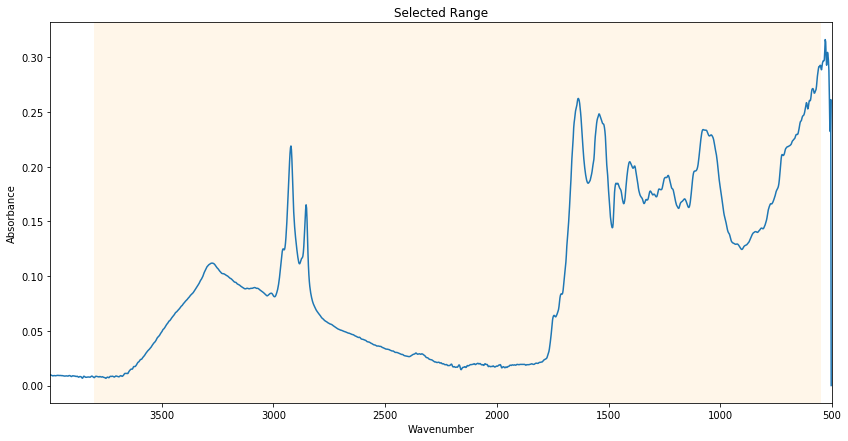

In [51]:
# We select a random spectrum:
n = np.random.randint(0,len(matrix)-1)
while not matrix[n]:
    n = np.random.randint(0,len(matrix)-1)

# we prepare the data
a = matrix[n][8][0]
b = matrix[n][8][1]
c = matrix[n][8][2]
xd = [a - x/c * (a-b) for x in range(c)]
yd = matrix[n][9]

# we draw the plot
plt.figure(figsize=(14,7))
plt.plot(xd,yd)
plt.xlim(a, b)

# and the selected wavenumbers
if len(wns) == 2 and einselechta == False:
    plt.axvspan(wns[0], wns[1], facecolor='papayawhip', alpha=0.5)
else:
    for i in wns:
        plt.axvline(x=i, c='black', lw=1)    
        
# labels
plt.xlabel('Wavenumber')
plt.ylabel('Absorbance')
if len(wns) == 2 and einselechta == False:
    plt.title('Selected Range')
else:
    plt.title('Selected Wavenumbers')

plt.show()

## Choose your own matrix

Now it is the time to export the data. Since *Loco mosquito* can deal with a lot of data, here is an algorithm to select only the spectra that we want for each variable. If you want to select all the characteristics of a variable, write ``"all"``

In [52]:
sel_species = "all"
sel_ages = "all"
sel_status = "all"
sel_country = "all"
sel_rear = "all"

And now, the following algorithm will extract from the spectra the desired intensities and the desired characteristics:

In [56]:
print(len(matrix))

43041


In [59]:
# We start the timer
a = time.time()
# We define the variable that will contain the final data
fida = []
csc = 0
ssel = 0
# If we have selected a range of wavenumbers, now it is time to change it into discrete wavenumbers
# First, we look for the boundaries of the data
for i in range(len(matrix)):
    if matrix[i]:
        kk = i
        break
if len(wns) == 2 and einselechta == False:
    resolution = 2
    if matrix[kk][8][0] < wns[0]:
        wns[0] = int(matrix[kk][8][0])
    if matrix[kk][8][1] > wns[-1]:
        wns[-1] = int(matrix[kk][8][-1])+1
    wns = list(range(wns[0],wns[1],-resolution))

# And start the algorithm to extract the info
for i in tqdm(matrix):
    # If that item exist
    if i:
        # If the item has the selected characteristics
        if sel_species == "all" or sel_species == "All" or sel_species == "ALL":
            sel_species = list_species
        if sel_ages == "all" or sel_ages == "All" or sel_ages == "ALL":
            sel_ages = list_ages
        if sel_status == "all" or sel_status == "All" or sel_status == "ALL":
            sel_status = list_status
        if sel_country == "all" or sel_country == "All" or sel_country == "ALL":
            sel_country = list_country
        if sel_rear == "all" or sel_rear == "All" or sel_rear == "ALL":
            sel_rear = list_rear
        if i[0] in sel_species and i[1] in sel_ages and i[2] in sel_status and i[3] in sel_country and i[6] in sel_rear:
            # we count the number of spectra that are removed because are too short for the range of wavenumbers selected
            if i[8][0] >= wns[0] and i[8][1] <= wns[-1]:
                pos = []
                for j in wns:
                    pos.append(int(round((((i[8][2] - 1) / (i[8][1] - i[8][0])) * (j - i[8][0])) + 1)) - 1)
                lint = []
                for k in pos:
                    lint.append(i[9][k])
                fida.append([i[0], i[1], i[2], i[3], str(int(i[4])), str(int(i[5])), i[6], str(int(i[7]))] + lint)
                ssel += 1
            else:
                csc += 1
fida = sorted(fida)
fida.insert(0,["Species", "Age", "Status", "Country", "ColDay", "MesDay", "RearCnd", "StoTime"] + wns)
if (csc) == 0:
    pass
elif (csc) == 1:
    print("1 spectrum has been discarded because was shorter than the selected wavenumbers")
else:
    print(str(csc) + " spectra have been discarded because were shorter than the selected wavenumbers")  
b = time.time()
print("This last process has lasted " + str(round(b-a,3)) + " s. The new matrix cotains " + str(ssel) + " spectra.")

100%|██████████| 43041/43041 [01:54<00:00, 376.49it/s]


This last process has lasted 114.402 s. The new matrix cotains 40741 spectra.


## Exporting the matrix

Now we export the matrix with the info in the same folder where the data were collected

In [60]:
with open(spectra_path.parent / Path("Mosquitoes_w_dates.dat"), 'w') as file:
    sc = csv.writer(file, delimiter='\t')
    for i in fida:
            sc.writerow(i)

In [61]:
print(spectra_path.parent)

/home/josh/Documents/Mosquito_Project/New_Data/Data
